Notebook for training our LNN in **modal** coordinates.

In [1]:
# NN packages
import jax
import jax.numpy as jnp
import optax

# Visualization packages
import matplotlib.pyplot as plt

# ML Models
from models.MDOF_LNN import Modal_Damped_LNN, Modal_MLP, Modal_Damped_LNN_withPrior

# Helper functions
from helpers import save_to_file, create_modal_training_data

In [2]:
import os  # Switch GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#### Data Extraction
In this section, we extract the `pose`, `velocity`, `acceleration`, `time`, `force amplitude` and `period` from each continuation simulation file. This dataset was created for **frequencies** ranging from $10.0Hz$ to $24.0Hz$ in steps of $0.2Hz$, where for each, the continuation parameter was the **forcing amplitude**.

The output is in **modal coordinates**.

In [3]:
FREQUENCY = True
withPrior = False

In [4]:
if FREQUENCY:
    filename='frequency_step_frequency_'
    path='Conx/modal_test'
    start=10.0
    stop=24.0
    step=0.2
else:
    filename='amplitude_step_amplitude_'
    path='Conx/modal_amp'
    start=0.1
    stop=2.0
    step=0.1

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=True)

Data saved to Conx/modal_test/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (2, 2001, 388), vel: (2, 2001, 388), acc: (2, 2001, 388)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (2001, 388), F: (388,), T: (388,), force: (2, 2001, 388)


In [5]:
train_data, test_data, info = create_modal_training_data(ml_data, path, split=0.2, seed=42)

Training data shape: (24658323, 2, 4), Testing data shape: (6243120, 2, 4)
Samples, # of Modes, [x, dx, ddx, force]
x_train.shape: (24658323, 2), dx_train.shape: (24658323, 2), ddx_train.shape: (24658323, 2), force_train.shape: (24658323, 2)
x_test.shape: (6243120, 2), dx_test.shape: (6243120, 2), ddx_test.shape: (6243120, 2), force_test.shape: (6243120, 2)


In [6]:
# Format dataset for LNN
# Position, velocity & total forcing conditions
train_x = train_data[:, :, :2]
train_dx = train_data[:, :, 1:3]
train_f = train_data[:, :, 3:]

test_x = test_data[:, :, :2]
test_dx = test_data[:, :, 1:3]
test_f = test_data[:, :, 3:]

train_data = train_x, train_f, train_dx
test_data = test_x, test_f, test_dx

In [7]:
train_data[0].shape, test_data[0].shape, train_data[1].shape, test_data[1].shape, train_data[2].shape, test_data[2].shape

((24658323, 2, 2),
 (6243120, 2, 2),
 (24658323, 2, 1),
 (6243120, 2, 1),
 (24658323, 2, 2),
 (6243120, 2, 2))

#### LNN
Here we define our LNN using 3 different NN for:
- Our kinetic energy $T \rightarrow MNN$:
- Our potential energy $V \rightarrow KNN$:
- Our damping energy $T \rightarrow DNN$:

In [8]:
if not withPrior:
    mnn_settings = {
        'name': 'MNN',
        'units': 128,
        'layers': 4,
        'input_shape': 4,
        'train_batch_size': 1028,
        'test_batch_size': 528,
        'shuffle': True,
        'seed': 69
        }
    
    dnn_settings = {
    'name': 'DNN',
    'units': 64,
    'layers': 4,
    'input_shape': 2,
    }

    knn_settings = {
        'name': 'KNN',
        'units': 128,
        'layers': 4,
        'input_shape': 4,
        }

else:
    knn_settings = {
        'name': 'KNN_NL',
        'units': 32,
        'layers': 4,
        'input_shape': 4,
        'train_batch_size': 128,
        'test_batch_size': 16,
        'shuffle': True,
        'seed': 69
        }

In [9]:
# Training parameters
lr = 1e-04
if not withPrior:
    mnn_optimizer = optax.adam(lr)
    dnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)

In [10]:
results_path = 'MDOF_LNN'
file_name='Modal_freq_update'
epochs = 20
show_every = 10

In [11]:
if not withPrior:
    a = Modal_Damped_LNN(
        mnn_module=Modal_MLP, 
        knn_module=Modal_MLP,       
        dnn_module=Modal_MLP, 
        mnn_settings=mnn_settings,
        knn_settings=knn_settings,
        dnn_settings=dnn_settings, 
        mnn_optimizer=mnn_optimizer, 
        knn_optimizer=knn_optimizer, 
        dnn_optimizer=dnn_optimizer, 
        info=info, 
        activation=jax.nn.tanh)
    
    # Start training LNN
    results = None
    _, _, _ = a.gather()
else:
    a = Modal_Damped_LNN_withPrior(
        nn_module=Modal_MLP,       
        nn_settings=knn_settings,
        nn_optimizer=knn_optimizer, 
        info=info, 
        activation=jax.nn.tanh)

    # Start training LNN
    results = None
    _ = a.gather()

In [12]:
# Standard loss
for _ in range(5):
    results = a.train(train_data, test_data, results, epochs=epochs, show_every=show_every)
    a.save_model(results, model_name=f"Iter_{results['last_epoch']}", folder_name=f"{results_path}/{file_name}")
print(f"Final loss: {results['best_loss']}")

Epoch: 0 | Train Loss: 35717.51953125 | Best Loss: 241.85250854 | Test Loss: 241.85250854
---------------------------------
Epoch: 10 | Train Loss: 0.00001364 | Best Loss: 0.00000620 | Test Loss: 0.00002920
---------------------------------
Epoch: 20 | Train Loss: 0.00000365 | Best Loss: 0.00000206 | Test Loss: 0.00000420
---------------------------------
Epoch: 30 | Train Loss: 0.00000211 | Best Loss: 0.00000057 | Test Loss: 0.00000162
---------------------------------
Epoch: 40 | Train Loss: 0.00000146 | Best Loss: 0.00000035 | Test Loss: 0.00000151
---------------------------------
Epoch: 50 | Train Loss: 0.00000109 | Best Loss: 0.00000025 | Test Loss: 0.00000740
---------------------------------
Epoch: 60 | Train Loss: 0.00000081 | Best Loss: 0.00000015 | Test Loss: 0.00000291
---------------------------------
Epoch: 70 | Train Loss: 0.00000065 | Best Loss: 0.00000012 | Test Loss: 0.00000013
---------------------------------
Epoch: 80 | Train Loss: 0.00000057 | Best Loss: 0.0000001

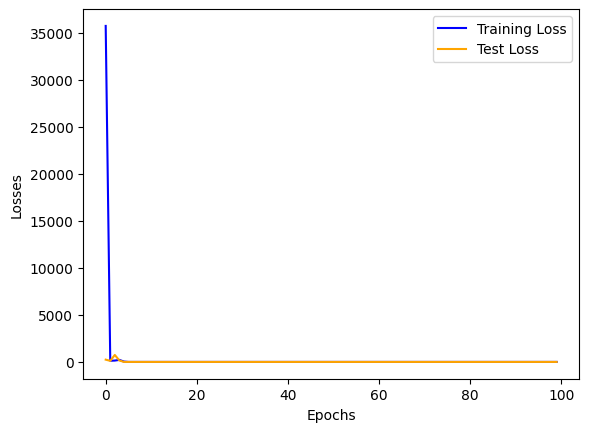

In [13]:
a.plot_results(results)

In [14]:
pred_acc_, pred_energy = a._predict(results)

In [15]:
limq11, limq12, limqd11, limqd12 = info["q1min"], info["q1max"], info["qd1max"], info["qd1min"]
limq21, limq22, limqd21, limqd22 = info["q2min"], info["q2max"], info["qd2max"], info["qd2min"]

q1a, q1da = jnp.linspace(limq11, limq12, 100), jnp.linspace(
    limqd11, limqd12, 100)
q1aa, q1daa = jnp.meshgrid(q1a, q1da)

q2a, q2da = jnp.linspace(limq21, limq22, 100), jnp.linspace(
    limqd21, limqd22, 100)
q2aa, q2daa = jnp.meshgrid(q2a, q2da)

q1a.shape, q1da.shape, q1aa.shape, q1daa.shape, q2a.shape, q2da.shape, q2aa.shape, q2daa.shape

((100,),
 (100,),
 (100, 100),
 (100, 100),
 (100,),
 (100,),
 (100, 100),
 (100, 100))

In [16]:
M, K, C = jax.vmap(pred_energy)(jnp.concatenate([q1aa.reshape(-1, 1), q2aa.reshape(-1, 1)], axis=1), jnp.concatenate([q1daa.reshape(-1, 1), q2daa.reshape(-1, 1)], axis=1))

L = M - K
M.shape, K.shape, C.shape, L.shape

((10000, 2), (10000, 2), (10000, 2), (10000, 2))

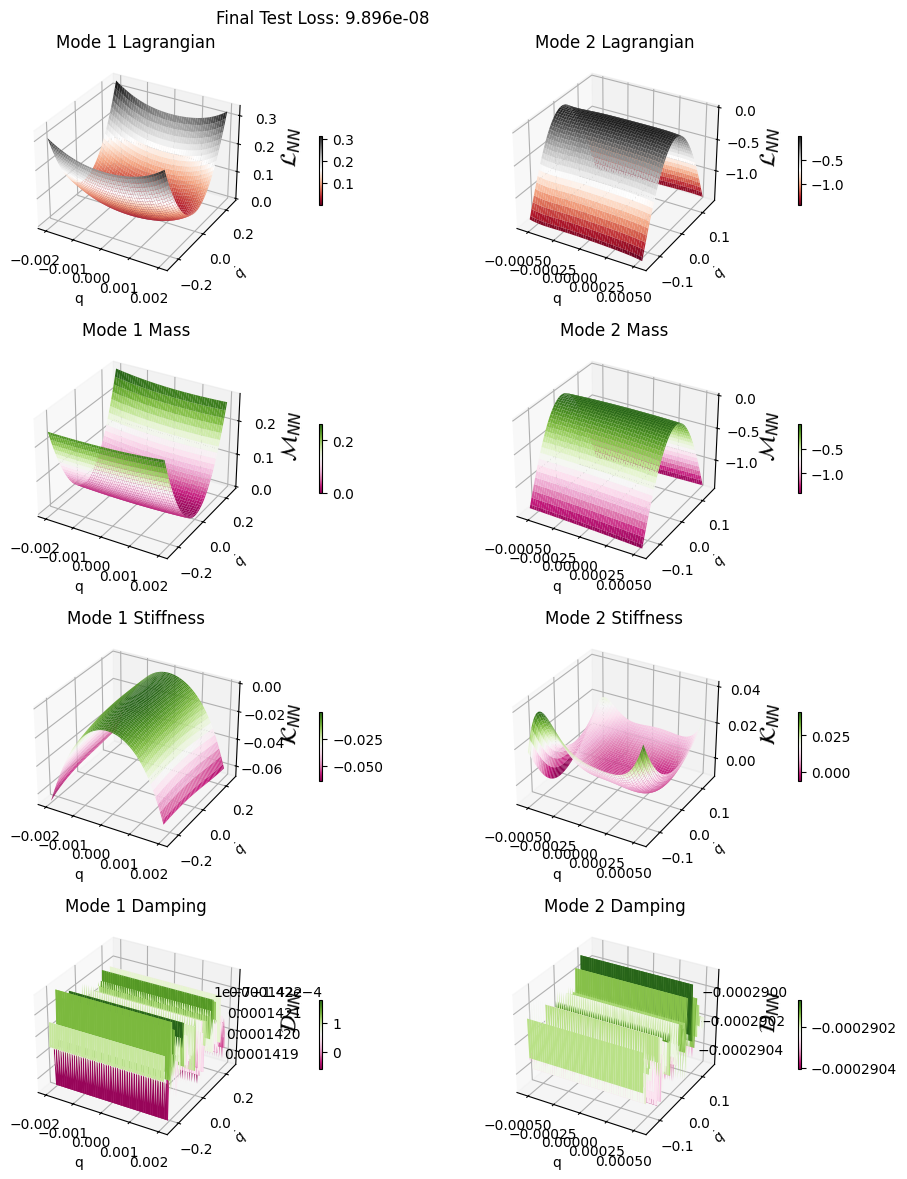

In [17]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

# --------------------------------- FUNCTIONS

# -------------------------------- Lagrangian
ax = fig.add_subplot(421, projection="3d")
m = ax.plot_surface(q1aa, q1daa, L[:, 0].reshape(q1aa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 1 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(422, projection="3d")
m = ax.plot_surface(q2aa, q2daa, L[:, 1].reshape(q2aa.shape), cmap="RdGy", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
ax.set_title(f"Mode 2 Lagrangian")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Mass
ax = fig.add_subplot(423, projection="3d")
m = ax.plot_surface(q1aa, q1daa, M[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(424, projection="3d")
m = ax.plot_surface(q2aa, q2daa, M[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Mass")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Stiffness
ax = fig.add_subplot(425, projection="3d")
m = ax.plot_surface(q1aa, q1daa, K[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(426, projection="3d")
m = ax.plot_surface(q2aa, q2daa, K[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Stiffness")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

# ---------------------------------- Damping
ax = fig.add_subplot(427, projection="3d")
m = ax.plot_surface(q1aa, q1daa, C[:, 0].reshape(q1aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 1 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

ax = fig.add_subplot(428, projection="3d")
m = ax.plot_surface(q2aa, q2daa, C[:, 1].reshape(q2aa.shape), cmap="PiYG", lw=0)
ax.set_xlabel("q")
ax.set_ylabel(r"$\dot{q}$")
ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
ax.set_title("Mode 2 Damping")
fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
# fig.savefig(f"./Modal_LNN/{file_name}-LD.png")


In [20]:
ddx = pred_acc_(test_x[::10, :, :], test_f[::10, :, :])
ddx.shape, test_dx.shape

((624312, 2), (6243120, 2, 2))

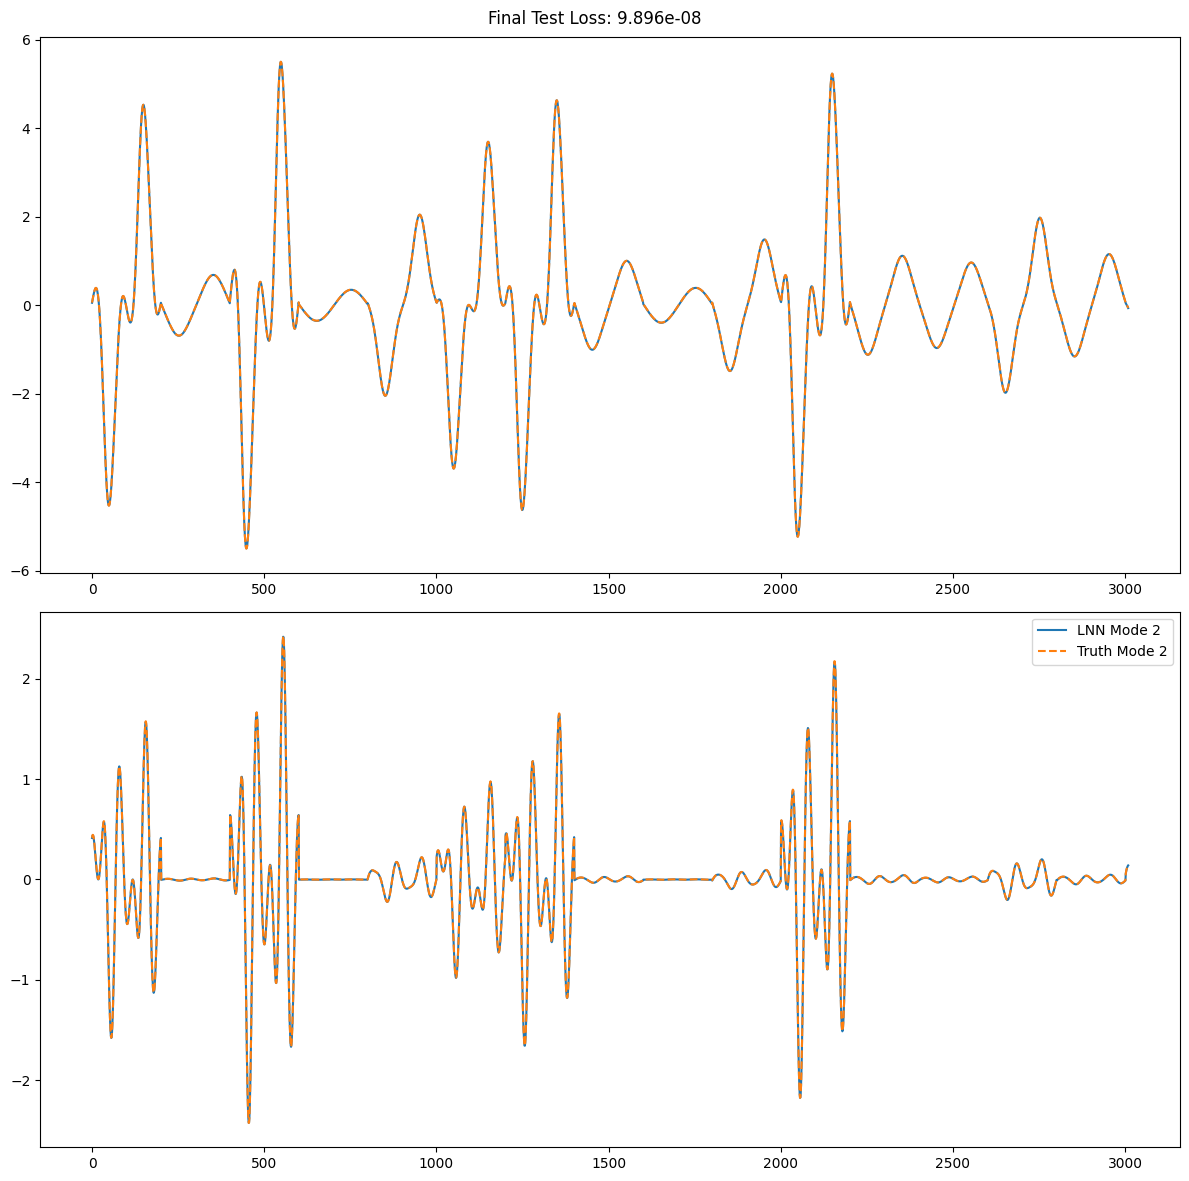

In [23]:
fig = plt.figure(figsize=(12, 12), tight_layout=True)
fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

ax = fig.add_subplot(211)
ax.plot(ddx[:301*10, 0], label="LNN Mode 1")
ax.plot(test_dx[:301*100:10, 0, -1], label="Truth Mode 1", linestyle='dashed')

ax = fig.add_subplot(212)
ax.plot(ddx[:301*10, 1], label="LNN Mode 2")
ax.plot(test_dx[:301*100:10, 1, -1], label="Truth Mode 2", linestyle='dashed')

plt.legend()